<a href="https://colab.research.google.com/github/acse-yw3821/CS-Notes/blob/master/ML_module_coursework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?id=1dtR470-kr9MhA_vytTgnLtdrr5X7HaXu" width="150"/>

### Name: [*Yann(Xinyan) Wang*]
### CID: [*02144885*]

# Instructions:

Follow the instructions below to complete the coursework and submit it:

1. Read the materials you will need to complete the coursework; you can find them in the github classroom repo provided together with this notebook. The provided materials are: 

  - The paper [*Gradient based learning applied to document recognition*](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) by Yann LeCunn where he describes the original form of the LeNet-5 architecture.

  - The paper [*Visualizing the Loss Landscape of Neural Nets*](https://arxiv.org/pdf/1712.09913.pdf).

  - This Jupyter Notebook template to fill in your answers (it contains some code to assist you).


2. Complete your coursework using this provided Jupyter Notebook template (use Google Colab or your local machine if it has a GPU and/or sufficient computational power).

3. Once you have completed your answers, upload your final notebook to the repo you got from the github classroom link (as you normally do). Make sure to have all the answers in there:

   - **All the cells in your final Jupyter Notebook should be executed before saving and uploading to github in order to have the output of the cells available in the uploaded version** (images you plot, training graphs generated with `livelossplot`, etc). We will not guarantee that if some code blocks are missing we will be able to rerun them for you.

   - Add comments in the code to explain what you are doing at every step. 

   - All answers requiring written answers (ie, not code) should be in markdown blocks in the Jupyter Notebook. This provided Jupyter Notebook template has allocated blocks for the questions, but you can add any coding or markdown blocks that you need.

4. The coursework is released on **Friday 13 May at 15:30h BST**, and the answers have to be submitted on **Saturday  21 May, 23:59h BST**. We will not accept late submissions.

    ***[BST stands for British Summer Time (local UK time)]***

<br>

---
<br>

### The coursework consists of a number of questions/exercises you have to complete. You will find them below.

## Imports

In [4]:
#!pip install pycm livelossplot
# download kaggle
!pip install -U -q kaggle

!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# your imports and initial checks here
%pylab inline

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary

Populating the interactive namespace from numpy and matplotlib


In [6]:
def set_seed(seed):
  """
  Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
  torch.backends.cudnn.enabled   = False

  return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

from google.colab import drive
drive.mount('/content/gdrive/')

Cuda installed! Running on GPU!
Mounted at /content/gdrive/


## 1-Load the medical MNIST dataset [10 points]
Go to this [kaggle dataset](https://www.kaggle.com/datasets/andrewmvd/medical-mnist/code) and download the data (see provided snippets below).

Format the data as you see fit to use it in your next questions. Explain the process you follow.

[**It is recommended that you convert the images to grayscale using** *torchvision transforms*]

Use the following snippets of code to help you download the data first:

In [7]:
# Get kaggle authentication json
# authorise kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"acseyw3821","key":"667432ed356bdb997323a9a2aba942d3"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
 
# check if kaggle successfully installed
!kaggle --version
# check if it's authorized
!kaggle competitions list

Kaggle API 1.5.12
ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         36           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        139           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        827           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        159           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1984           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13821         

In [8]:
# ! mkdir ~/.kaggle
# ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# ! ls ~/.kaggle

# Download and unzip dataset
! kaggle datasets download -d andrewmvd/medical-mnist
! mkdir ./medical-mnist
! unzip -q ./medical-mnist.zip -d medical-mnist

 99% 84.0M/84.8M [00:00<00:00, 298MB/s]
100% 84.8M/84.8M [00:00<00:00, 288MB/s]


In [9]:
BASE_PATH = "./medical-mnist/"
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(BASE_PATH, transform=transform)


print("Information of Dataset:")
print(train_data[0][0].shape)
print(train_data.classes)
print("Index for training set: ", train_data.class_to_idx)

Information of Dataset:
torch.Size([3, 64, 64])
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Index for training set:  {'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}


In [10]:
import os
def count(BASE_PATH, dir_path_lists):
  ls = []
  for folder_name in dir_path_lists:
    dir = BASE_PATH + folder_name + "/"
    path, dirs, files = next(os.walk(dir))
    ls.append(len(files))
  return ls

cnt_list = count(BASE_PATH, train_data.classes)
print("labels:", train_data.classes)
print("number:", cnt_list)


labels: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
number: [10000, 8954, 10000, 10000, 10000, 10000]


In [11]:
train_loader = DataLoader(train_data, batch_size=len(train_data), num_workers=0, shuffle=False)
data, labels = next(iter(train_loader))
mean = [torch.mean(data.flatten()).item()]
std = [torch.std(data.flatten()).item()]
print('mean: ', mean[0])
print('standard deviation: ', std[0])
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                 transforms.ToTensor(),
                 transforms.Normalize(mean[0], std[0])])
train_path = "./medical-mnist"
train_data = torchvision.datasets.ImageFolder(train_path, transform=transform)
print(train_data[0][0].shape)

mean:  0.35834768414497375
standard deviation:  0.28219738602638245
torch.Size([1, 64, 64])


## 2-Plot data [5 points]
Plot 25 images of the training set together with their corresponding label names.






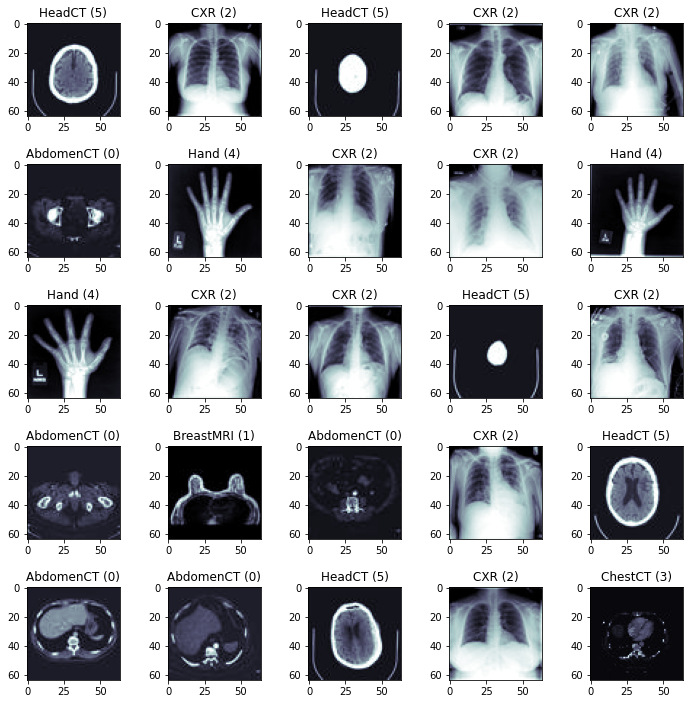

In [12]:
# your code goes here
def show_batch(dataset, nr=4, nc=4):
  fig, axarr = plt.subplots(nr, nc, figsize=(10, 10))
  for i in range(nr):
    for j in range(nc):
      idx = random.randint(0, len(train_data))
      sample, target = train_data[idx]
      # print(sample.shape)
      try:
        axarr[i][j].imshow(sample) # if PIL
      except:
        axarr[i][j].imshow(sample.permute(1,2,0).squeeze(), cmap='bone') # if tensor of shape CHW
      target_name = train_data.classes[target]
      axarr[i][j].set_title("%s (%i)"%(target_name, target))
  fig.tight_layout(pad=1.5)
  plt.show()


show_batch(train_data, 5, 5)


## 3-Prepare your LeNet-5 network [10 points]
Use the code provided in the Jupyter Notebook template and modify it as you see fit to be able to perform a forward pass using a single dummy tensor input **x**.

Do you need to modify the size of any layers of the network for the Medical MNIST dataset? If yes, explain how you did it and implement the changes.

The lines of code that will do the forward pass and print the network are provided in the template.

In [13]:
#     make modifications in the code below
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()

    # self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=1)
    # Firstly, as we've processed the Medical MNIST dataset from 3 channels to 1 channel,
    # we should set the first layer to have each filter with 1 channel and 0 padding.
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)   
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)   
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Secondly, if you want to input the 64x64 size of dataset to this model directly,
    # we need to modify the size of the c5 layer from 16*5*5 to 16*13*13.
    self.c5 = nn.Linear(16*13*13, 120)    
    self.f6 = nn.Linear(120, 84)

    # Finally, our datasets have 6 classes so the output size should be 6 instead of 10. 
    self.output = nn.Linear(84, 6)  
    self.act = nn.ReLU()           
  

  def forward(self, x):
    x = self.act(self.c1(x))    
    x = self.act(self.s2(x))   
    x = self.act(self.c3(x))   
    x = self.act(self.s4(x))    
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))     
    x = self.act(self.c5(x))       
    x = self.act(self.f6(x))    
    return self.output(x)          
  
# Dummy input of the same size as the Medical-MNIST images
x = torch.ones((1, 1, 64, 64)) ## generate a dummy tensor x
model = LeNet5() ## get an instance of your model and call it model
y = model(x) # if you have called your instance something different than model, modify this line of code
print(model)
print(x.shape, y.shape)

LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)
torch.Size([1, 1, 64, 64]) torch.Size([1, 6])


## 4-Create a training, validation split [5 points]
Split the data using `sklearn.model_selection.StratifiedShuffleSplit`:

- 90\% of the data in the training set
- 10\% of the data in the validation set

Verify the stratified shuffle split by plotting a histogram of the classes in the training and validation set.

Prepare the downloaded datasets to be used with your modified network from the previous section.

In [14]:
print(train_data)

Dataset ImageFolder
    Number of datapoints: 58954
    Root location: ./medical-mnist
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.35834768414497375, std=0.28219738602638245)
           )


In [15]:
# your code goes here
tmp_loader = DataLoader(train_data, batch_size=len(train_data), shuffle = False)
data, labels = next(iter(tmp_loader))

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(data, labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train  = np.array(data)[indices[0]], np.array(labels)[indices[0]]
X_validation,y_validation =  np.array(data)[indices[1]], np.array(labels)[indices[1]]

In [16]:
print("X_train.shape:", X_train.shape)
print("X_validation.shape:", X_validation.shape)

X_train.shape: (53058, 1, 64, 64)
X_validation.shape: (5896, 1, 64, 64)


<BarContainer object of 6 artists>

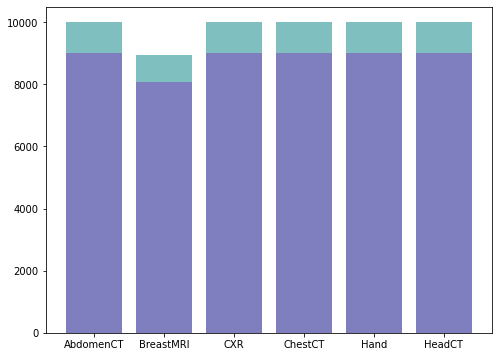

In [17]:
classes = ["AbdomenCT", "BreastMRI","CXR", "ChestCT","Hand", "HeadCT"]

number_of_classes_train = []
number_of_classed_validation = []
train_index = np.array(labels)[indices[0]]
validation_index = np.array(labels)[indices[1]]

for i in range(6):
    number_of_classes_train.append(np.sum(train_index==i))
    number_of_classed_validation.append(np.sum(validation_index==i))

classes = ["AbdomenCT", "BreastMRI", "CXR", "ChestCT", "Hand", "HeadCT"]
plt.figure(figsize=(8,6))
plt.bar(classes,number_of_classes_train,align='center',color='navy', alpha = 0.5, tick_label = classes)
plt.bar(classes,number_of_classed_validation,align='center',color='teal', alpha = 0.5, bottom = number_of_classes_train)
# fig,axes = plt.subplots(1,2)
# plt.figure()
# # plt.subplots_adjust()
# sns.barplot(classes, number_of_classes_train, ax=axes[0])
# sns.barplot(classes, number_of_classed_validation, ax=axes[1])

## 5-Grid search [20 points]
From  the  list  below,  select  two  hyperparameters  and  perform  a  2D  grid-search  to  find  the  optimal values for these two hyperparameters.  The range of values to test are provided.  Justify your choice of the two hyperparameters you want to tune (write a paragraph in a markdown cell explaining why you chose these two particular parameters). 

The list of hyperparameters to choose from is:

a)  Random Number Seed:  **42**  [31, 42, 53] \
b)  Learning Rate:  **1e-2**  [1e-1, 1e-2, 1e-3] \
c)  Momentum:  **0.5**  [0.2, 0.5, 0.8] \
d)  Batch Size:  **64**  [64, 128, 512] \
e)  Number of epochs:  **30**  [10, 30, 50]

The **values in bold** next to each hyperparameter are the values you need to use if you are not tuning this particular hyperparameter.  The values between square brackets are the values to use if you choose to tune this particular hyperparameter. Fixed hyperparameters:

- Optimiser: SGD+momentum
- Test batch size: 1000

Write the results in two tables (one for the loss and one for the accuracy) where the columns and rows are the first and second hyperparameter have selected. You can use markdown tables or create the table in python.

Using *livelossplot* to display the training of some grid-search runs (don't need to plot all of them, choose the ones you think are more relevant to explain your hyperparameter search strategy).

Select the best values for the two hyperparameters you have chosen to optimise and **justify your choice**.

In [18]:
# your code goes here
seed = 42
batch_size = 64
n_epochs = 30
test_batch_size = 1000

In [19]:
print(train_data)

Dataset ImageFolder
    Number of datapoints: 58954
    Root location: ./medical-mnist
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.35834768414497375, std=0.28219738602638245)
           )


In [20]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_validation = torch.tensor(X_validation)
y_validation = torch.tensor(y_validation)

# create the TensorDatasets containing train, validate
medical_training = TensorDataset(X_train, y_train.long())
medical_validate = TensorDataset(X_validation, y_validation.long())

# pass datasets to DataLoaders
train_loaders = DataLoader(medical_training, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loaders = DataLoader(medical_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [21]:
def train(model, optimizer, criterion, data_loader):
  """Return the loss function value and training accuracy"""
  model.train()
  train_loss, train_accuracy = 0, 0
  for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      a2 = model(X.view(-1, 1, 64, 64))
      loss = criterion(a2, y)
      loss.backward()
      train_loss += loss*X.size(0)
      y_pred = F.log_softmax(a2, dim=1).max(1)[1]
      train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
      optimizer.step()  
      
  return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
  """Return loss function value and training accuracy for the validation dataset"""
  model.eval()
  validation_loss, validation_accuracy = 0., 0.
  for X, y in data_loader:
      with torch.no_grad():
          X, y = X.to(device), y.to(device)
          a2 = model(X.view(-1, 1, 64, 64))
          loss = criterion(a2, y)
          validation_loss += loss*X.size(0)
          y_pred = F.log_softmax(a2, dim=1).max(1)[1]
          validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
          
  return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
  """Return prediction classes."""
  model.eval()
  ys, y_preds = [], []
  for X, y in data_loader:
      with torch.no_grad():
          X, y = X.to(device), y.to(device)
          a2 = model(X.view(-1, 1, 64, 64))
          y_pred = F.log_softmax(a2, dim=1).max(1)[1]
          ys.append(y.cpu().numpy())
          y_preds.append(y_pred.cpu().numpy())
          
  return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [22]:
# main function for training, returns a trained model as well as the final loss function value and accuracy for the validation set.
def train_model(momentum, lr, visualize=True):
  set_seed(seed)
  model = LeNet5().to(device)
  # we add L2-regularization using weight_decay
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = 1e-2)
  # we choose the CrossEntropy to be the loss function 
  criterion = nn.CrossEntropyLoss()
  
  # do livelossplot if visualize turned-on
  if visualize:
      liveloss = PlotLosses()

  for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loaders)
    validation_loss, validation_accuracy = validate(model, criterion, validation_loaders)
    
    # do livelossplot if visualize turned-on 
    if visualize: 
      logs = {}

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

      
  return model, validation_loss, validation_accuracy

In [23]:
# define lists for learning rates and momentums 
lrs = [1e-1, 1e-2, 1e-3]
momentums = [0.2, 0.5, 0.8]
# allocate arrays for loss and accuracy
losses = np.zeros((3, 3))
accuracies = np.zeros((3, 3))
# simple hand-written grid search
for i in range(3):
  for j in range(3):
    model, losses[i][j], accuracies[i][j] = train_model(momentums[i], lrs[j], visualize=False)

In [24]:
# format changing for printing
losses = losses.tolist()
losses[0].insert(0, momentums[0])
losses[1].insert(0, momentums[1])
losses[2].insert(0, momentums[2])

accuracies = accuracies.tolist()
accuracies[0].insert(0, momentums[0])
accuracies[1].insert(0, momentums[1])
accuracies[2].insert(0, momentums[2])

In [25]:
#package for making tables
import prettytable as pt
#define head
head = ["momentum / learning-rate", 1e-1, 1e-2, 1e-3]

# make table for loss
loss_t = pt.PrettyTable()
loss_t.field_names = head
loss_t.add_row(losses[0])
loss_t.add_row(losses[1])
loss_t.add_row(losses[2])
print("Grid Search table for loss: \n")
print(loss_t)

Grid Search table for loss: 

+--------------------------+--------------------+----------------------+----------------------+
| momentum / learning-rate |        0.1         |         0.01         |        0.001         |
+--------------------------+--------------------+----------------------+----------------------+
|           0.2            | 1.7914382219314575 | 0.015263812616467476 | 0.01882578805088997  |
|           0.5            | 1.791456937789917  | 0.014707920141518116 | 0.01601889543235302  |
|           0.8            | 1.7917306423187256 | 0.015415613539516926 | 0.013856258243322372 |
+--------------------------+--------------------+----------------------+----------------------+


In [26]:
# make table for accuracy score
accuracy = pt.PrettyTable()
accuracy.field_names = head
accuracy.add_row(accuracies[0])
accuracy.add_row(accuracies[1])
accuracy.add_row(accuracies[2])
print("Grid Search table for accuracy score: \n")
print(accuracy)

Grid Search table for accuracy score: 

+--------------------------+---------------------+--------------------+--------------------+
| momentum / learning-rate |         0.1         |        0.01        |       0.001        |
+--------------------------+---------------------+--------------------+--------------------+
|           0.2            | 0.16960651289009498 | 0.9960990502035278 | 0.996268656716418  |
|           0.5            | 0.16960651289009498 | 0.9966078697421981 | 0.9967774762550882 |
|           0.8            | 0.16960651289009498 | 0.9960990502035278 | 0.9972862957937585 |
+--------------------------+---------------------+--------------------+--------------------+


In [27]:
#package for making tables
import prettytable as pt
#define head
head = ["momentum / learning-rate", 1e-1, 1e-2, 1e-3]

# make table for loss
loss_t = pt.PrettyTable()
loss_t.field_names = head
loss_t.add_row(losses[0])
loss_t.add_row(losses[1])
loss_t.add_row(losses[2])
print("Grid Search table for loss: \n")
print(loss_t)

Grid Search table for loss: 

+--------------------------+--------------------+----------------------+----------------------+
| momentum / learning-rate |        0.1         |         0.01         |        0.001         |
+--------------------------+--------------------+----------------------+----------------------+
|           0.2            | 1.7914382219314575 | 0.015263812616467476 | 0.01882578805088997  |
|           0.5            | 1.791456937789917  | 0.014707920141518116 | 0.01601889543235302  |
|           0.8            | 1.7917306423187256 | 0.015415613539516926 | 0.013856258243322372 |
+--------------------------+--------------------+----------------------+----------------------+


In [28]:
# make table for accuracy score
accuracy = pt.PrettyTable()
accuracy.field_names = head
accuracy.add_row(accuracies[0])
accuracy.add_row(accuracies[1])
accuracy.add_row(accuracies[2])
print("Grid Search table for accuracy score: \n")
print(accuracy)

Grid Search table for accuracy score: 

+--------------------------+---------------------+--------------------+--------------------+
| momentum / learning-rate |         0.1         |        0.01        |       0.001        |
+--------------------------+---------------------+--------------------+--------------------+
|           0.2            | 0.16960651289009498 | 0.9960990502035278 | 0.996268656716418  |
|           0.5            | 0.16960651289009498 | 0.9966078697421981 | 0.9967774762550882 |
|           0.8            | 0.16960651289009498 | 0.9960990502035278 | 0.9972862957937585 |
+--------------------------+---------------------+--------------------+--------------------+


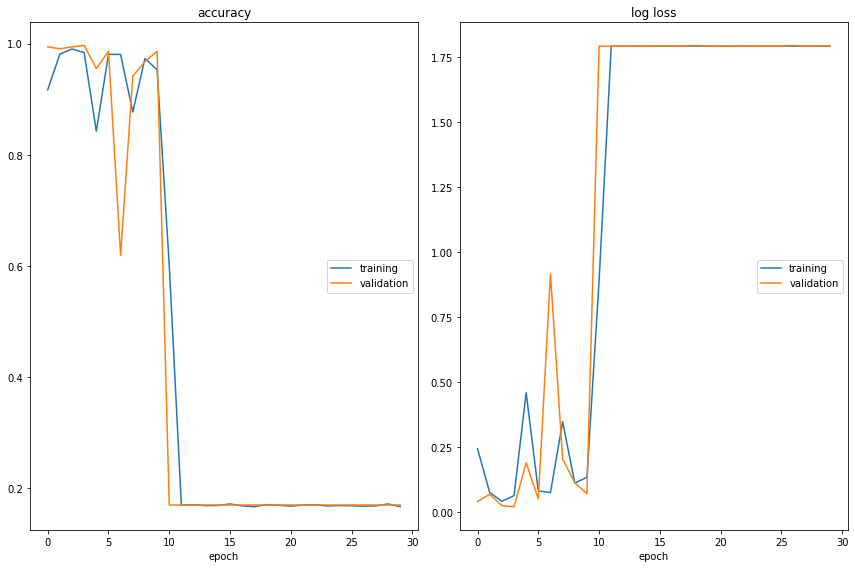

accuracy
	training         	 (min:    0.166, max:    0.990, cur:    0.166)
	validation       	 (min:    0.170, max:    0.997, cur:    0.170)
log loss
	training         	 (min:    0.041, max:    1.792, cur:    1.792)
	validation       	 (min:    0.020, max:    1.794, cur:    1.791)


In [29]:
lr = 1e-1
momentum = 0.5
example_run, _ , _ = train_model(momentum, lr, visualize=True)

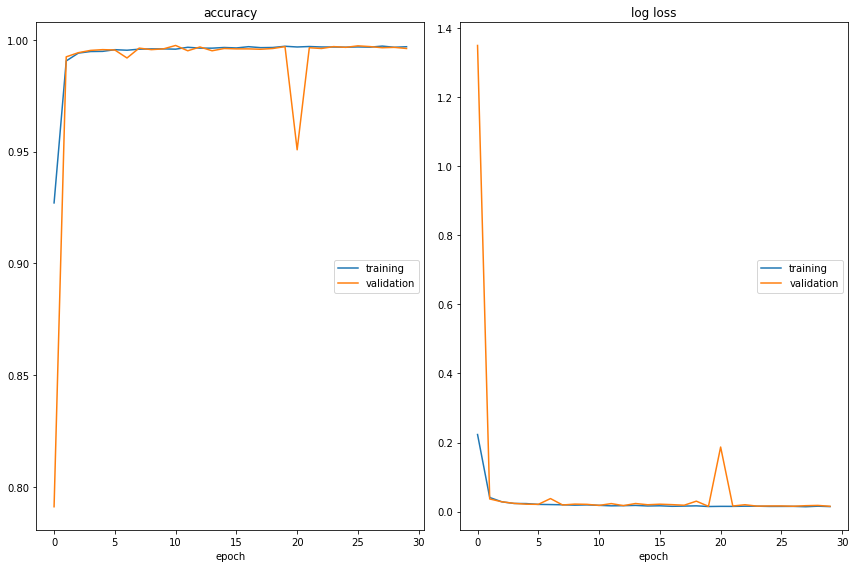

accuracy
	training         	 (min:    0.927, max:    0.997, cur:    0.997)
	validation       	 (min:    0.791, max:    0.997, cur:    0.996)
log loss
	training         	 (min:    0.014, max:    0.223, cur:    0.014)
	validation       	 (min:    0.015, max:    1.350, cur:    0.015)


In [30]:
lr = 1e-2
momentum = 0.2
example_run, _ , _ = train_model(momentum, lr, visualize=True)

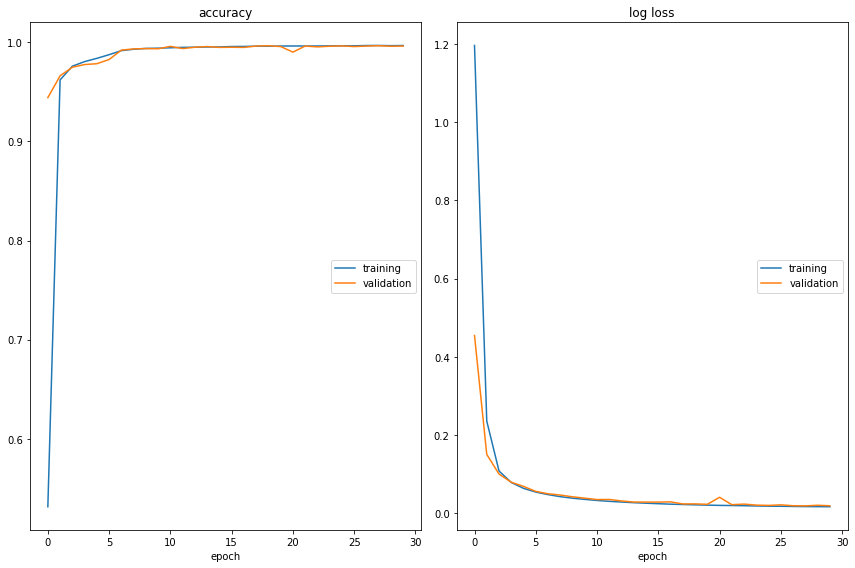

accuracy
	training         	 (min:    0.531, max:    0.997, cur:    0.997)
	validation       	 (min:    0.944, max:    0.997, cur:    0.996)
log loss
	training         	 (min:    0.016, max:    1.197, cur:    0.016)
	validation       	 (min:    0.019, max:    0.455, cur:    0.019)


In [31]:
lr = 1e-3
momentum = 0.2
example_run, _ , _ = train_model(momentum, lr, visualize=True)

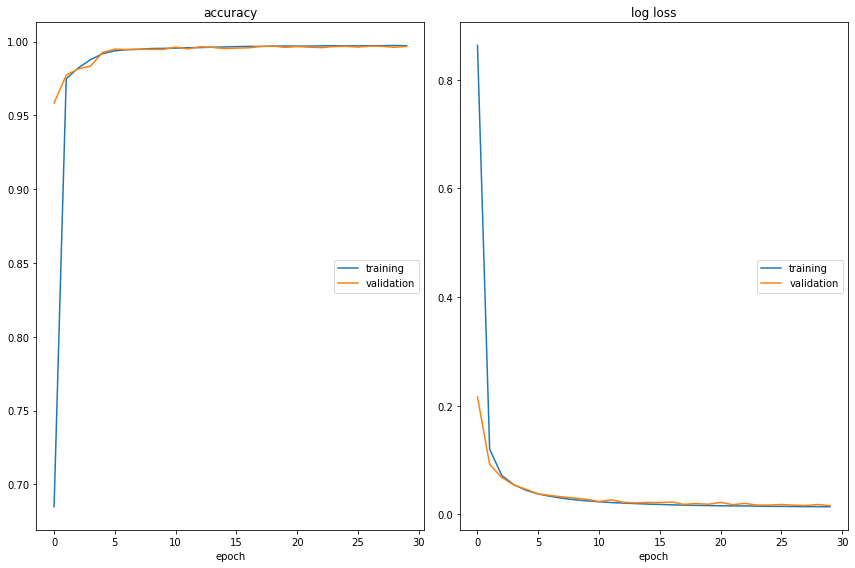

accuracy
	training         	 (min:    0.685, max:    0.997, cur:    0.997)
	validation       	 (min:    0.958, max:    0.997, cur:    0.997)
log loss
	training         	 (min:    0.014, max:    0.863, cur:    0.014)
	validation       	 (min:    0.016, max:    0.216, cur:    0.016)


In [32]:
lr = 1e-3
momentum = 0.5
example_run, _ , _ = train_model(momentum, lr, visualize=True)

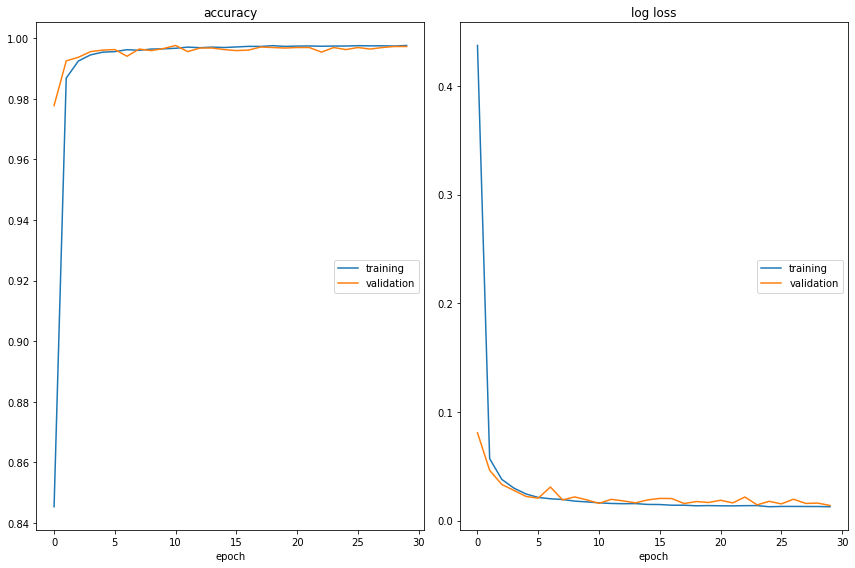

accuracy
	training         	 (min:    0.845, max:    0.998, cur:    0.998)
	validation       	 (min:    0.978, max:    0.998, cur:    0.997)
log loss
	training         	 (min:    0.013, max:    0.437, cur:    0.013)
	validation       	 (min:    0.014, max:    0.081, cur:    0.014)


In [33]:
lr = 1e-3
momentum = 0.8
example_run, _ , _ = train_model(momentum, lr, visualize=True)

## 6-Train with best hyperparameters [5 points]

Once you have your two best hyperparameters, retrain the model by combining your split datasets **as you see fit** and explain why you chose this particular combination. Report the final accuracy on the test set. Use *livelossplot* to plot the values of the training evolution and explain changes in performance with your new combination of datasets.

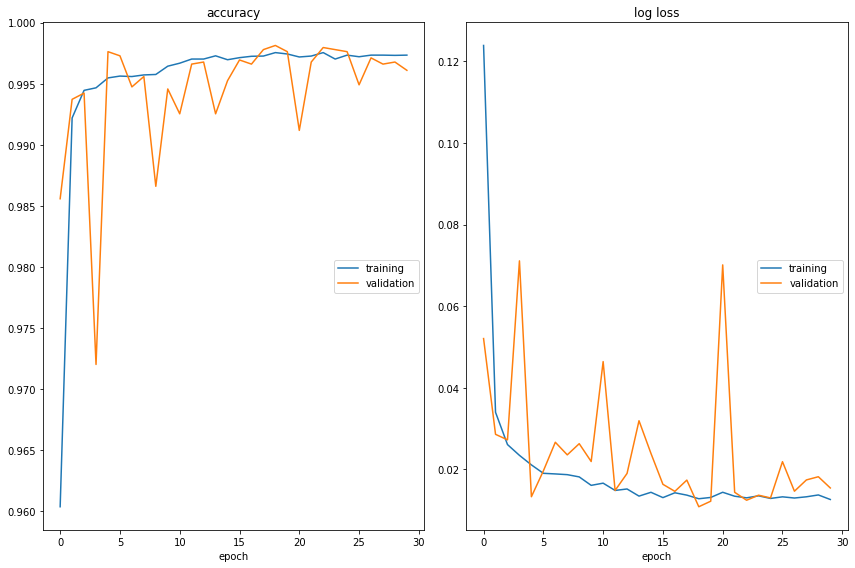

accuracy
	training         	 (min:    0.960, max:    0.998, cur:    0.997)
	validation       	 (min:    0.972, max:    0.998, cur:    0.996)
log loss
	training         	 (min:    0.013, max:    0.124, cur:    0.013)
	validation       	 (min:    0.011, max:    0.071, cur:    0.015)


In [52]:
# your code goes here
lr = 1e-2
momentum = 0.8
example_run, _ , _ = train_model(momentum, lr, visualize=True)

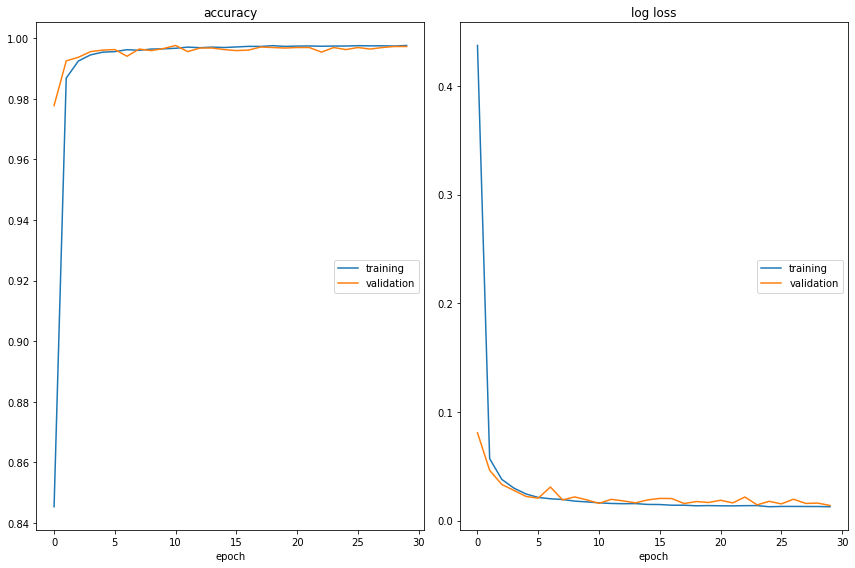

accuracy
	training         	 (min:    0.845, max:    0.998, cur:    0.998)
	validation       	 (min:    0.978, max:    0.998, cur:    0.997)
log loss
	training         	 (min:    0.013, max:    0.437, cur:    0.013)
	validation       	 (min:    0.014, max:    0.081, cur:    0.014)


In [53]:
blr = 1e-3
bmomentum = 0.8
bmodel, bloss , baccuracy = train_model(bmomentum, blr, visualize=True)

In [54]:
criterion = nn.CrossEntropyLoss()

train_loader2 = DataLoader(medical_training, batch_size=len(medical_training), shuffle=True, num_workers=0)
data2, labels2 = next(iter(train_loader2))
shuffler2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, train_size=0.9, random_state=42).split(data2, labels2)
indices2 = [(train_idx2, test_idx) for train_idx2, test_idx in shuffler2][0]
# X_train2, y_train2 = np.array(data2)[indices2[0]], np.array(labels2)[indices2[0]]
X_test, y_test = np.array(data2)[indices2[1]], np.array(labels2)[indices2[1]]
# X_train2 = torch.tensor(X_train2)
# y_train2 = torch.tensor(y_train2)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)
# medical_training2 = TensorDataset(X_train2, y_train2.long())
medical_test = TensorDataset(X_test, y_test.long())
# train_loaders2 = DataLoader(medical_training2, batch_size=batch_size, shuffle=True, num_workers=0)
test_loaders = DataLoader(medical_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

print("The number of all data in training set is: {0:}, while in test set is: {1:}".format(len(indices2[0]), len(indices2[1])))

test_loss, test_accuracy = validate(bmodel, criterion, test_loaders)    
print("Test Loss: %1.3f" % test_loss.item(), "Test Accuracy: %1.3f" % test_accuracy.item())

The number of all data in training set is: 47752, while in test set is: 5306
Test Loss: 0.012 Test Accuracy: 0.998


In [55]:
# generate predictions and ground truths by evaluating the model
y_pred, y_gt = evaluate(bmodel, test_loaders)

# Create CM From Data
cm = ConfusionMatrix(actual_vector=y_gt, predict_vector=y_pred) 

# print the confusion matrix
print(cm)

Predict   0         1         2         3         4         5         
Actual
0         900       0         0         0         0         0         

1         0         806       0         0         0         0         

2         0         0         896       3         1         0         

3         0         0         0         900       0         0         

4         0         0         2         1         897       0         

5         0         0         0         0         1         899       





Overall Statistics : 

95% CI                                                            (0.99745,0.99954)
ACC Macro                                                         0.9995
ARI                                                               0.99633
AUNP                                                              0.99909
AUNU                                                              0.99911
Bangdiwala B                                                      0.99694
Bennett S 

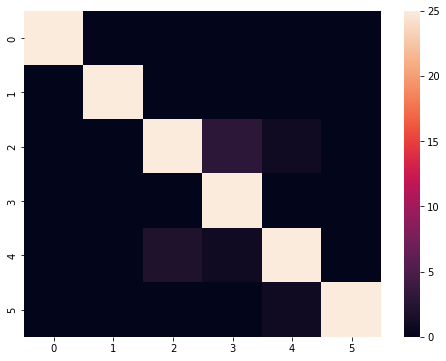

In [57]:
def to_raw_matrix(cm):
    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    plt.figure(figsize=(8,6))
    return plt_cm

import seaborn as sns

rcm = to_raw_matrix(cm) #store the confusion matrix values
sns.heatmap(rcm, vmin=0, vmax=25) # use sensible limits to be able to see where the network struggles to identify digits

The test accuracy is 0.998, test loss is 0.012.
The result is very good, even better than the validation. 

The performance is surprising, with little problem of overfitting and underfitting.

## 7-Comparison with original LeNet implementation  [10 points]}
Read the paper *Gradient based learning applied to document recognition* provided. What are the main differences between their implementation and the one you are using in this coursework?

[**You only need to read and understand the paper until section** III. RESULTS AND COMPARISON WITH OTHER METHODS, *B. Results*, **included, which finishes on page 11 (you can ignore the rest)**]



I think the main diffrences between their implementation and the one I am using is that, their model settings and their implementation using Graph Transformer Networks (GTN).

GTN can train multi_module systems globally using Gradient-Based methods.

I listed the difference as followed:


**1. Pooling layers s2, s4.** 

Ther are trainable parameters in their implementation. While in my implementation I simply use the max pooling layer with no trainable parameters in my pooling layers.

**2. Convolutional layer C3.** 

My implementation has more trainable parameters in C3 bacause my implement connects to all the output feature maps of s2 layer. In their implementation, each unit of C3 only connects to a subset of the output of s2. 



**3. Layer C5.** 

- Their: convolutional layer.
- Mine: fully-connected layer.


**4.  The activation function is different.** 
- Their: Sigmoid function.
- Mine: ReLU function.


**5. Output layer is different.** 

- Their: Euclidian Radial Basis Function units (RBF),  each class has one with 84 inputs.

- Mine: Each unit of the ouput fully-connected layer has 84 inputs.


**6. The loss function.** 


- Their: MSE.

- Mine: cross-entropy.


**7. They use several versions of LeNet-5. We only use one.** 


**8. Module.** 

GTN takes one or more graphs as input, and produces a graph as output.

Gradient-Based Learning can minimize a global loss function as it can train all the modules globally.



## 8-Number of parameters in LeNet-5 [5 points]

Calculate how many trainable parameters the LeNet network you have implemented for this coursework has, and compare it to the number of parameters of the original LeNet network described in the paper you read in the previous question. Explain how you calculate the number of parameters for both cases.

[**answers that only contain the number of parameters without justification will be awarded 0 points**]

#### your answers here


The trainable parameters the LeNet network I have implemented for this coursework is: 

1. Convolutional Layer C1: 6x(5x5x1+1)=156.
  - `6`: the number of filters (the number of output channel), 
  - `5`: the size of each filter (kernel size),
  - `1` is the number of input channel. 

2. Convolutional Layer C3: 16x(6x5x5+1)=2416.
  - `16`: the number of output channel, 
  - `5`: the size of each filter (kernel size),
  - `6`: is the number of input channel. 

3. Fully-connected Layer C5: (16x13x13+1)x120=324600.
   - `16x13x13`: the number of input feature,
   - `120` : the number of output feature. 

4.  Fully-connected layer F6: (120+1)x84=10164.
  - `120`: input feature.
  - `84`: output feature. 

5. Output layer output: (84+1)x6=510.
  - `84`: the input feature.
  - `6` : the output feature. 

The number of the trainbale parameters is 156+2416+324600+10164+510=337846. 

In [43]:
# your code goes here (if you want to use a code cell in this question)
summary(bmodel, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 60, 60]             156
              ReLU-2            [-1, 6, 60, 60]               0
         MaxPool2d-3            [-1, 6, 30, 30]               0
              ReLU-4            [-1, 6, 30, 30]               0
            Conv2d-5           [-1, 16, 26, 26]           2,416
              ReLU-6           [-1, 16, 26, 26]               0
         MaxPool2d-7           [-1, 16, 13, 13]               0
              ReLU-8           [-1, 16, 13, 13]               0
            Linear-9                  [-1, 120]         324,600
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                    [-1, 6]             510
Total params: 337,846
Trainable params:

## 9-Visualising loss landscapes paper - 1 [10 points]

Read the provided paper *Visualising the Loss Landscape of Neural Nets*. This paper contains a lot of advanced concepts, but you only need to read and understand it well up to and including section 4 (Proposed Visualisation: Filter-Wise Normalisation) to answer the questions below. In section 4 you don't need to fully understand the rationale for doing Filter-Wise Normalisation, but you do need to understand what Filter-Wise Normalisation is.

Answer the following question (in a markdown cell):
- What are the dimensions of the parameters $\delta$, $\eta$, $\alpha$ and $\beta$ in equation (1) using your LeNet network? [5 points]
- Describe what is the role of each of these parameters [5 points]

Explain in detail and justify your answers.

(1) $\delta$ and $\eta$ are two direction vectors which have the same dimension as the number of trainable parameters in the model. $\alpha$ and $\beta$ are 1D scalars to parametrize the surface by scaling $\delta$ and $\eta$.

(2) $\delta$ and $\eta$ are two random direction vectors which show two changing directions of the parameters. $\alpha$ and $\beta$ are to scale the step of change in the two directions $\delta$ and $\eta$ and to parametrize the surface so that we can calculate its values alongside a 2D grid. The loss surface can be defined with respect to the model parameters. As modern convolutional networks can have millions of parameters a multitude of ways have been developed to use them to visualize the loss surface in lower dimensions. This model proposes a solution of visualizing the loss surface with respec to modifying the weights of the underlying neural net in random, normalized directions: *f($\alpha$, $\beta$)=L($\theta$+$\alpha$$\delta$+$\beta$$\eta$)*, Where $\delta$ and $\eta$ are random directions in the vector space of the model weights. This method made it possible to parametrize the surface with $\alpha$ and $\beta$ parameters and therefore we can calculate its values alongside a 2D grid.

## 10-Visualise loss landscapes - 2 [20 points]

Use the formula described in equation (1) in the paper in combination with the Filter-Wise Normalisation to generate landscape plots in these two cases:
- your final trained model (output of question *6*).
- your randomly initialised model.

In both cases, use 25 values for $\alpha$ and 25 values for $\beta$ to generate a 2D plot with 625 points.

Use the provided snippets of code in the Jupyter Notebook template to assist you in generating the plots and to guide you in the functions you will need to implement.

Analyse, compare and discuss your plots. How are they different? and why? Justify the choices you make along the generation process of plotting the loss landscapes (for example, but not limited to, the range your choose for your $\alpha$ and $\beta$ values).

[**you can use a subset of the data to generate the plots, but explain what effect this will have in the results**]

In [44]:
# The following snippets of code are only to assist you. You can decide to use 
# them or not. They are only intended to provide you with some functionality
#  you may find useful when trying to generate the loss landscape plots.


# function to create random directions:
def create_random_directions(weights, ignore1D=False, seed=42):
    torch.manual_seed(seed)
    direction = [torch.randn(w.size()).to(device) for w in weights]
    
    # apply filter normalisation, where every perturbation d in direction has the same norm as its corresponding w in weights
    for d, w in zip(direction, weights):
        if ignore1D and d.dim() <= 1:
            d.fill_(0)
        d.mul_(w.norm()/(d.norm() + 1e-10)) # add small perturbation to avoid division by zero

    return direction


# function to update weigths
def update_weights(model, origin_weights, x_dir, y_dir, dx=0.1, dy=0.1):
    updates = [x.to(device)*dx + y.to(device)*dy for (x, y) in zip(x_dir, y_dir)]
    for (p, w, u) in zip(model.parameters(), origin_weights, updates):
        p.data = w + u
    return None


# function to plot loss landscape as a surface
def plot_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(8, 8),subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, loss_landscape, cmap='viridis', edgecolor='none',
                       linewidth=0, antialiased=True,  rstride=1, cstride=1,)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    ax.set_zlabel(r'Loss')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# function to plot loss landscape as a contour
def contour_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(7, 7))
    surf = ax.contourf(xx, yy, loss_landscape, cmap='viridis', levels=100)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    # mark the minima point
    minima_x= np.unravel_index(np.argmin(loss_landscape),loss_landscape.shape)
    minima_y = np.min(loss_landscape)
    ax.plot(xx[minima_x], yy[minima_x],'r.')
    off1 = -140
    off2 = 50
    bbox = dict(boxstyle="round", fc='salmon', alpha=0.6)
    arrowprops = dict(arrowstyle="->", connectionstyle="arc3,rad=0.")
    annotation = ax.annotate(('minima achieves at ({0:.4f}, {1:.4f}),\nminimal loss = {2:f}'.format(xx[minima_x], yy[minima_x], minima_y)), 
                                 xy=(xx[minima_x], yy[minima_x]), xytext=(off1, off2), textcoords='offset points',
                              bbox=bbox, arrowprops=arrowprops, size=15)
    annotation.set_visible(True)
    plt.show()


# BONUS: functions to compute the angle between 2 random vectors
# in high-dimensional spaces two random vectors are quite likely to be
# orthogonal (or almost). No points involved here, this is just for fun!
#
def angle(vec1, vec2):
    return torch.acos(torch.dot(vec1, vec2)/(vec1.norm()*vec2.norm())).item()

def rad2deg(angle):
    return angle*180/np.pi

def concat_torch_list(torch_list):
    for i, t in enumerate(torch_list):
        torch_list[i] = t.flatten()
    return torch.cat(torch_list)

Final trained model (output of question 6).

In [47]:
# your code here
# set alpha and beta
import copy

alpha = np.linspace(-1, 1, 25)
beta = np.linspace(-1, 1, 25)

# create meshgrid
xx, yy = np.meshgrid(alpha, beta)

# make a copy for my best model, in case the value of 'theta' changes during the updating process
bmodel_copy = copy.deepcopy(bmodel)
# create two random directions by using two different random seeds
delta = create_random_directions(bmodel_copy.parameters(), ignore1D=False, seed=42)
eta = create_random_directions(bmodel_copy.parameters(), ignore1D=False, seed=31)
# get the original weights of the best model
init_weights=bmodel.state_dict().values()

# calculate loss functions
loss_landscape = np.zeros_like(xx)
for i in range(25):
  for j in range(25):
    dx = xx[i][j]
    dy = yy[i][j]
    # calculate loss for each grid
    update_weights(bmodel_copy, init_weights, delta, eta, dx, dy)
    loss_landscape[i, j] = validate(bmodel_copy, criterion, test_loaders)[0].item()

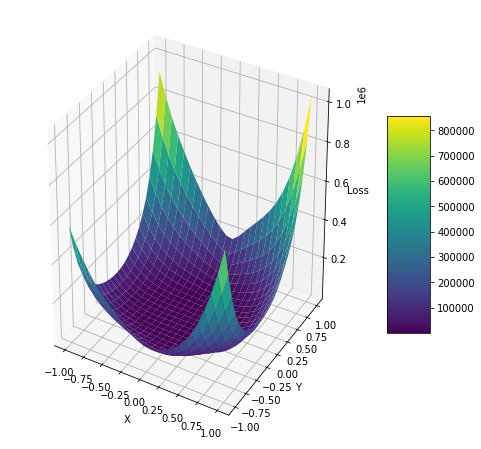

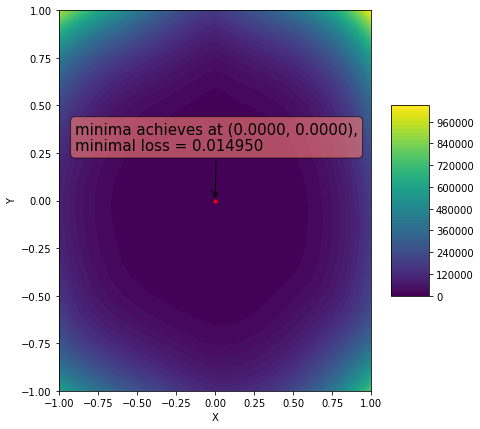

In [49]:
plot_loss_landscape(xx, yy, loss_landscape)
contour_loss_landscape(xx, yy, loss_landscape)

randomly initialised model.

In [50]:
# set alpha and beta
alpha = np.linspace(-0.05, 0.05, 25)
beta = np.linspace(-0.05, 0.05, 25)

# create meshgrid
xx, yy = np.meshgrid(alpha, beta)

# create randomly initialised model
random_model=LeNet5()
random_model.to(device)

# your code here
# make a copy for my best model, in case the value of 'theta' changes during the updating process
random_model_copy = copy.deepcopy(random_model)
# create two random directions by using two different random seeds
delta2 = create_random_directions(random_model.parameters(), ignore1D=False, seed=42)
eta2 = create_random_directions(random_model.parameters(), ignore1D=False, seed=31)
# get the original weights of the best model
# init_weights2=random_model.state_dict().values()

# calculate loss functions
loss_landscape = np.zeros((25, 25))
for i in range(25):
  for j in range(25):
    dx = xx[i][j]
    dy = yy[i][j]

    # calculate loss for each grid
    update_weights(random_model_copy, random_model.parameters(), delta2, eta2, dx, dy)
    loss_landscape[i, j] = validate(random_model_copy, criterion, test_loaders)[0].item()

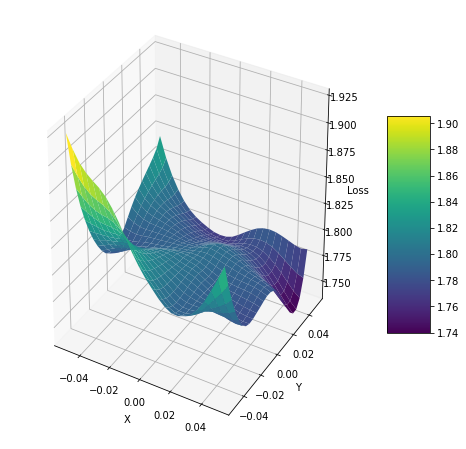

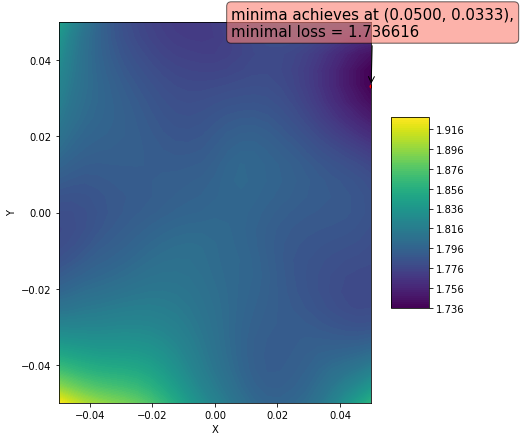

In [51]:
plot_loss_landscape(xx, yy, loss_landscape)
contour_loss_landscape(xx, yy, loss_landscape)

#### your answers here

For a randomly initialised model, the center point may not the the global minima within its nergibourhood. Since it is randomly initialised, it may not reach best answer, in another word, the end of the optimization.

And, the loss surface is sharper in the contour plot. It means the initialised answer is very uncorrect, it loss is improving by the trainning.